# FNO for Darcy Flow Reconstruction with Sparse Observations: Voronoi Embedding

In [23]:
# packages
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.layers.embeddings import GridEmbedding2D
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from scipy.spatial import cKDTree
from scipy import sparse

device = 'cpu'

In [3]:
# load original dataset
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16], n_tests=[100],
        test_batch_sizes=[32],
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 


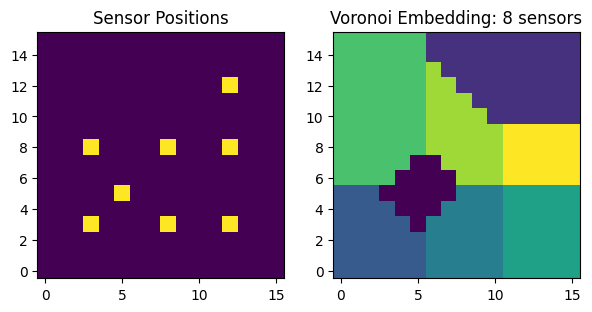

In [27]:
def build_voronoi_matrix(grid_shape, sensor_positions):
    """Build sparse matrix V such that: u_voronoi = V @ u_sensor

    Parameters:
        grid_shape: (H, W), e.g. (16, 16)
        sensor_positions: list or array of sensor positions [[x1,y1], [x2,y2], ...]

    Returns:
        V_matrix: scipy.sparse.csr_matrix of shape (H*W, n_sensors)
        idx_map: np.array of shape (H, W), shows which sensor each pixel belongs to
    """
    H, W = grid_shape
    n_pixels = H * W
    positions = np.array(sensor_positions)
    n_sensors = len(positions)

    # All grid coordinates
    grid_x, grid_y = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)  # shape: [H*W, 2]

    # KDTree to find nearest sensor
    tree = cKDTree(positions)
    _, idx = tree.query(grid_points)  # shape: [H*W], each entry ∈ [0, n_sensors)

    # Build sparse V_matrix
    row_indices = np.arange(n_pixels)
    col_indices = idx
    data = np.ones_like(row_indices, dtype=np.float32)
    V_matrix = sparse.coo_matrix((data, (row_indices, col_indices)), shape=(n_pixels, n_sensors)).tocsr()

    idx_map = idx.reshape(grid_shape)  # For visualization/debugging

    return V_matrix, idx_map

# set sensor locations
positions = np.array([
    # [0,15], [2, 15], [5, 15], [10, 15],
    # [15,0], [15,2], [15,5], [15,6], [15,10], [15,13], [15,15],
    # [15, 7],
    [5,5], [12,12], 
    [3,3], [3,8], [3,12], [8,3], [8,8], [8,12]
]) # get u_sensor: u_sensor = np.array([u[x, y] for x, y in positions])  # shape [n_sensors]

n_sensors = len(positions)
grid_shape = (16, 16)

pos_mat = np.zeros((1, 16, 16))
for pos in positions:
    pos_mat[0, pos[0], pos[1]] = 1

V_matrix, V_labels = build_voronoi_matrix(grid_shape, positions)

fig,axes = plt.subplots(1, 2, figsize=(7,7))

axes[0].imshow(pos_mat[0], origin='lower')
axes[0].set_title('Sensor Positions')

im = axes[1].imshow(V_labels, origin='lower')
# plt.colorbar(im, ax=axes[1])
axes[1].set_title(f'Voronoi Embedding: {n_sensors} sensors')
plt.show()

In [28]:
# generate sparse dataset (voronoi embedding) with original dataset
from torch.utils.data import DataLoader

def scipy_to_torch(scipy_mat):
    coo = scipy_mat.tocoo()
    indices = torch.tensor([coo.row, coo.col], dtype=torch.long)
    values = torch.tensor(coo.data, dtype=torch.float32)
    shape = coo.shape
    return torch.sparse_coo_tensor(indices, values, torch.Size(shape)).coalesce()

def extract_u_sensor(y, positions):
    # y: (B, H, W)
    sensors = [y[:, x, y_] for x, y_ in positions]
    return torch.stack(sensors, dim=-1)  # (B, n_sensors)

# V_matrix: scipy to torch
V_matrix = scipy_to_torch(V_matrix).to(device)

# modify x to y*mask for train dataset
mod_train_data = []
for batch in train_loader.dataset:
    y = batch['y'].to(device).float()  # shape: (B, 16, 16)
    u_sensor = extract_u_sensor(y, positions)
    x_mod = torch.matmul(V_matrix, u_sensor.T).T        # shape: (B, 256)
    x_mod = x_mod.view(-1, 16, 16)                     # reshape to (B, 16, 16)
    
    mod_train_data.append({'x': x_mod, 'y': y})

mod_train_loader = DataLoader(mod_train_data, batch_size=32, shuffle=True)

# modify x to y*mask for test dataset
mod_test_loaders = {}
for res, test_loader in test_loaders.items():
    mod_test_data = []
    for batch in test_loader.dataset:
        y = batch['y'].to(device).float()
        u_sensor = extract_u_sensor(y, positions)
        x_mod = torch.matmul(V_matrix, u_sensor.T).T        # shape: (B, 256)
        x_mod = x_mod.view(-1, 16, 16)                     # reshape to (B, 16, 16)
        mod_test_data.append({'x': x_mod, 'y': y})

    mod_test_loaders[res] = DataLoader(mod_test_data,
                                       batch_size=test_loader.batch_size,
                                       shuffle=False,
                                       num_workers=0,
                                       pin_memory=True)

# print shape
for batch in mod_test_loaders[16]:
    print("x shape:", batch['x'].shape)
    print("y shape:", batch['y'].shape)
    break  # 只打印一个 batch


x shape: torch.Size([32, 1, 16, 16])
y shape: torch.Size([32, 1, 16, 16])


C:\Users\liuya\AppData\Local\Temp\ipykernel_2136\616837459.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  indices = torch.tensor([coo.row, coo.col], dtype=torch.long)


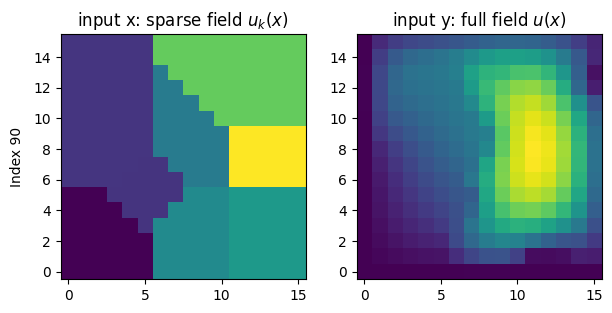

In [29]:
# check modified dataset

index = 90
data = mod_train_loader.dataset[index]
x = data['x']
y = data['y']

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.annotate(f"Index {index}", xy=(-0.15, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
masked_x = np.ma.masked_where(x[0] == 0, x[0])
mod_cmap = plt.cm.viridis.copy()
mod_cmap.set_bad(color='white') 
ax.imshow(masked_x, cmap=mod_cmap, origin='lower')
ax.set_title('input x: sparse field $u_k(x)$')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(y.squeeze(), origin='lower')
ax.set_title('input y: full field $u(x)$')
plt.show()

In [30]:
# model setup
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=64,
             positional_embedding="grid",
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4769473 parameters.


In [31]:
# model setup
optimizer = AdamW(model.parameters(),
                                lr=4e-3,
                                weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# loss functions
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}


print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(1

In [32]:
# train
trainer = Trainer(model=model, n_epochs=100,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=mod_train_loader,
              test_loaders=mod_test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses,
              save_every=10,
              save_dir="./ckpt/sparse_voronoi/",
              # resume_from_dir="./ckpt/sparse_mask/"
              )

Training on 1000 samples
Testing on [50] samples         on resolutions [16].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=5.18, avg_loss=0.6908, train_err=21.5871
Eval: 16_h1=0.5604, 16_l2=0.3147
[Rank 0]: saved training state to ./ckpt/sparse_voronoi/
[1] time=5.24, avg_loss=0.5393, train_err=16.8531
Eval: 16_h1=0.5375, 16_l2=0.2855
[2] time=5.12, avg_loss=0.5277, train_err=16.4920
Eval: 16_h1=0.5339, 16_l2=0.2892
[3] time=5.33, avg_loss=0.5195, train_err=16.2337
Eval: 16_h1=0.5282, 16_l2=0.2781
[4] time=5.25, avg_loss=0.5091, train_err=15.9090
Eval: 16_h1=0.5341, 16_l2=0.2853
[5] time=5.29, avg_loss=0.5065, train_err=15.8274
Eval: 16_h1=0.5230, 16_l2=0.2760
[6] time=6.82, avg_loss=0.5015, train_err=15.6724
Eval: 16_h1=0.5149, 16_l2=0.2669
[7] time=6.70, avg_loss=0.4958, train_err=15.4932
Eval: 16_h1=0.5147, 16_l2=0.2715
[8] time=6.70, avg_loss=0.4897, train_err=15.3027
Eval: 16_h1=0.5142, 16_l2=0.2731
[9] time=6.84, avg_loss=0.4875, train_err=15.2333
Eval: 16_h1=0.5076,

{'train_err': 0.4041592460125685,
 'avg_loss': 0.01293309587240219,
 'avg_lasso_loss': None,
 'epoch_train_time': 7.3694642000000385,
 '16_h1': tensor(0.5352),
 '16_l2': tensor(0.2556)}

In [33]:
# save model
model.save_checkpoint(save_folder='./model', save_name='fno_sparse_voronoi')

In [ ]:
# reload model
model_reload = FNO.from_checkpoint('./model', save_name='fno_sparse_voronoi')

C:\Users\liuya\AppData\Local\Temp\ipykernel_2136\3778765448.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


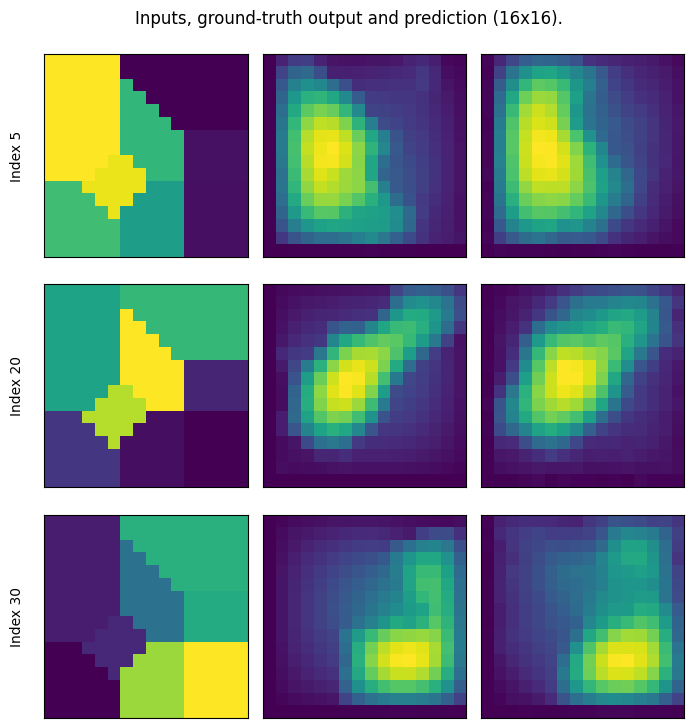

In [39]:
model_use = model
# model_use = model_reload

test_samples = mod_test_loaders[16].dataset

tests = [5, 20, 30]

fig = plt.figure(figsize=(7, 2.5*len(tests)))
for id, test_id in enumerate(tests):
    data = test_samples[test_id]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model_use(x.unsqueeze(0))

    ax = fig.add_subplot(len(tests), 3, id*3 + 1)
    ax.annotate(f"Index {test_id}", xy=(-0.1, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
    masked_x = np.ma.masked_where(x[0] == 0, x[0])
    mod_cmap = plt.cm.viridis.copy()
    mod_cmap.set_bad(color='white') 
    ax.imshow(masked_x, cmap=mod_cmap, origin='lower')
    # ax.imshow(x[1], origin='lower')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, id*3 + 2)
    ax.imshow(y.squeeze(), origin='lower')
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, id*3 + 3)
    ax.imshow(out.squeeze().detach().numpy(), origin='lower')
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()